# Clustering: Clustering de Lineas con SAX y KMeans

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt
import matplotlib.dates as mdates

from pyspark import SparkContext, SQLContext
from pyspark.ml.feature import VectorAssembler

from sax_kmeans import SAXKMeans
from pyspark.sql import SQLContext
from pyspark.sql.types import *


sqlCtx = SQLContext(sc)

In [3]:
sc.addPyFile("sax_kmeans.py")

## 2. Carga de datos

#####  Carga de los datos para festivos y laborables

In [35]:
#Carga de los datos para los dias Laborables
df_lineas_laborables=sqlContext.sql("select fecha,linea,sum(n_viajeros) as n_viajeros from emt_smartbus.viajeros_tramos_master_nooutliers where festivo=0 and \
                                  (dia_semana='L' or dia_semana='M' or dia_semana='X' or dia_semana='J' or dia_semana='V') group by fecha,linea ORDER BY fecha")

#Carga de los datos para los dias Festivos
df_lineas_festivos=sqlContext.sql("select fecha,linea,sum(n_viajeros) as n_viajeros from emt_smartbus.viajeros_tramos_master_nooutliers where \
                                  (dia_semana='S' or dia_semana='D' or festivo=1) group by fecha,linea ORDER BY fecha")


In [36]:
df_lineas_laborables.show()

+--------+-----+----------+
|   fecha|linea|n_viajeros|
+--------+-----+----------+
|20150102|  601|      1040|
|20150102|    2|     10349|
|20150102|    1|      7266|
|20150102|  176|      3856|
|20150102|  402|      4648|
|20150102|  203|      2604|
|20150102|  401|      2113|
|20150102|    3|      6895|
|20150102|    4|      5213|
|20150102|    5|      5350|
|20150102|  178|      3756|
|20150102|  799|       518|
|20150102|  403|      6728|
|20150102|  602|       379|
|20150102|    6|     13963|
|20150102|    8|      5721|
|20150102|  200|      2749|
|20150102|  174|      2095|
|20150102|  177|      1412|
|20150102|  173|      2977|
+--------+-----+----------+
only showing top 20 rows



In [37]:
df_lineas_festivos.show()

+--------+-----+----------+
|   fecha|linea|n_viajeros|
+--------+-----+----------+
|20150101|   55|      2636|
|20150101|   32|      4449|
|20150101|   18|      1920|
|20150101|  215|       206|
|20150101|   20|      3833|
|20150101|   21|      3618|
|20150101|   37|      1347|
|20150101|   28|      3514|
|20150101|   15|      1923|
|20150101|   38|      3081|
|20150101|   40|       963|
|20150101|   16|       925|
|20150101|   41|       925|
|20150101|   34|      5341|
|20150101|   14|      1985|
|20150101|   42|       682|
|20150101|   45|      2079|
|20150101|   11|       688|
|20150101|   12|       835|
|20150101|   29|      1352|
+--------+-----+----------+
only showing top 20 rows



##### Eliminamos las lineas "raras" (lineas que tienen una gran cantidad de 0s)

In [38]:
from pyspark.sql.functions import col

lineas_raras_laborables= [13,84,88,97,98,180,193,196,201,211,225,227,233,276,288,297,299,301,316,321,322,333,339,349,372,399,405,410,431,434,435,436,440,443,445,446,449,465,499,533,543,
               544,550,552,558,560,588,610,611,622,623,647,660,663,666,679,685,690,700,701,712,722,733,735,739,744,777,778,785,801,802,803,804,805,806,807,808,809,810,811,812,
               815,816,817,818,819,820,822,824,825,826,829,841,848,851,854,855,862,877,885,886]

for l in lineas_raras_laborables:
    df_lineas_laborables = df_lineas_laborables.filter((col('linea') != l))

df_lineas_laborables.show()

+--------+-----+----------+
|   fecha|linea|n_viajeros|
+--------+-----+----------+
|20150102|   21|     16108|
|20150102|  456|       406|
|20150102|   56|      8376|
|20150102|  129|      1220|
|20150102|   32|     13432|
|20150102|   61|     10304|
|20150102|  130|      4189|
|20150102|   31|     16491|
|20150102|   67|      4727|
|20150102|  106|      5959|
|20150102|  506|       727|
|20150102|  138|      6144|
|20150102|   11|      3308|
|20150102|  247|      1976|
|20150102|   47|      6744|
|20150102|   82|      2494|
|20150102|  116|      4189|
|20150102|  516|       570|
|20150102|  145|      4269|
|20150102|   42|      3281|
+--------+-----+----------+
only showing top 20 rows



In [39]:
lineas_raras_festivos= [13,90,190,199,204,214,217,274,277,300,334,335,337,375,377,399,440,528,551,554,
                        603,610,633,657,660,666,670,676,679,725,730,763,766,779,800,809,810,812,814,853,855,869]

for l in lineas_raras_festivos:
    df_lineas_festivos = df_lineas_festivos.filter((col('linea') != l))

df_lineas_festivos.show()

+--------+-----+----------+
|   fecha|linea|n_viajeros|
+--------+-----+----------+
|20150101|  210|       754|
|20150101|   10|      3444|
|20150101|   74|      1859|
|20150101|  110|       590|
|20150101|  310|       731|
|20150101|  510|       697|
|20150101|  151|       344|
|20150101|   30|      2268|
|20150101|   63|      1600|
|20150101|  112|       383|
|20150101|  512|       313|
|20150101|  146|      4496|
|20150101|   27|      4562|
|20150101|   64|      1432|
|20150101|  517|       539|
|20150101|  141|      1475|
|20150101|   36|      1679|
|20150101|   71|      1158|
|20150101|  132|      1846|
|20150101|  172|        43|
+--------+-----+----------+
only showing top 20 rows



## 4. Clustering

### 4.1 Laborables

##### Fase de Preprocesado

In [8]:
#Ordenamos por fecha
df_lineas_laborables_pivot=df_lineas_laborables.orderBy(df_lineas_laborables.fecha.asc(),df_lineas_laborables.linea.asc())
df_lineas_laborables_pivot.show()

+--------+-----+----------+
|   fecha|linea|n_viajeros|
+--------+-----+----------+
|20150102|    1|      7266|
|20150102|    2|     10349|
|20150102|    3|      6895|
|20150102|    4|      5213|
|20150102|    5|      5350|
|20150102|    6|     13963|
|20150102|    7|      3142|
|20150102|    8|      5721|
|20150102|    9|     11662|
|20150102|   10|     12331|
|20150102|   11|      3308|
|20150102|   12|      3706|
|20150102|   14|     11144|
|20150102|   15|      4385|
|20150102|   16|      3854|
|20150102|   17|     13188|
|20150102|   18|      5353|
|20150102|   19|     10295|
|20150102|   20|     13154|
|20150102|   21|     16108|
+--------+-----+----------+
only showing top 20 rows



In [9]:
from pyspark.sql.functions import first

#transponer las columnas para que tengamos una columna por linea
df_lineas_laborables_pivot = df_lineas_laborables_pivot.groupBy('linea').pivot('fecha').agg(first("n_viajeros"))
df_lineas_laborables_pivot.show()

+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---

In [10]:
#Missing values
df_lineas_laborables_filter=df_lineas_laborables_pivot.na.fill(0.0)
df_lineas_laborables_filter.show()

+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---

In [11]:
#Ordenamos por fecha
df_lineas_laborables_filter=df_lineas_laborables_filter.orderBy(df_lineas_laborables_filter.linea.asc())
df_lineas_laborables_filter.show()

+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---

In [12]:
#Guardamos el dataset en cache
df_lineas_laborables_filter.cache()

DataFrame[linea: int, 20150102: bigint, 20150105: bigint, 20150107: bigint, 20150108: bigint, 20150109: bigint, 20150112: bigint, 20150113: bigint, 20150114: bigint, 20150115: bigint, 20150116: bigint, 20150119: bigint, 20150120: bigint, 20150121: bigint, 20150122: bigint, 20150123: bigint, 20150126: bigint, 20150127: bigint, 20150128: bigint, 20150129: bigint, 20150130: bigint, 20150202: bigint, 20150203: bigint, 20150204: bigint, 20150205: bigint, 20150206: bigint, 20150209: bigint, 20150210: bigint, 20150211: bigint, 20150212: bigint, 20150213: bigint, 20150216: bigint, 20150217: bigint, 20150218: bigint, 20150219: bigint, 20150220: bigint, 20150223: bigint, 20150224: bigint, 20150225: bigint, 20150226: bigint, 20150227: bigint, 20150302: bigint, 20150303: bigint, 20150304: bigint, 20150305: bigint, 20150306: bigint, 20150309: bigint, 20150310: bigint, 20150311: bigint, 20150312: bigint, 20150313: bigint, 20150316: bigint, 20150317: bigint, 20150318: bigint, 20150320: bigint, 201503

##### Fase de Clustering

In [13]:
# vector assembler
cols=[c for c in df_lineas_laborables_filter.columns if c not in {'linea'}]
assembler1 = VectorAssembler(inputCols=cols, outputCol="serie")
df_lineas_laborables_predict = assembler1.transform(df_lineas_laborables_filter)

In [45]:
sax_laborables = SAXKMeans(featuresCol="serie",predictionCol="prediction",k=8,numIntervals=5,alphabetSize=250,maxIter=15)


In [46]:
sax_laborables.fit(df_lineas_laborables_predict)

In [47]:
res_laborables = sax_laborables.transform(df_lineas_laborables_predict)

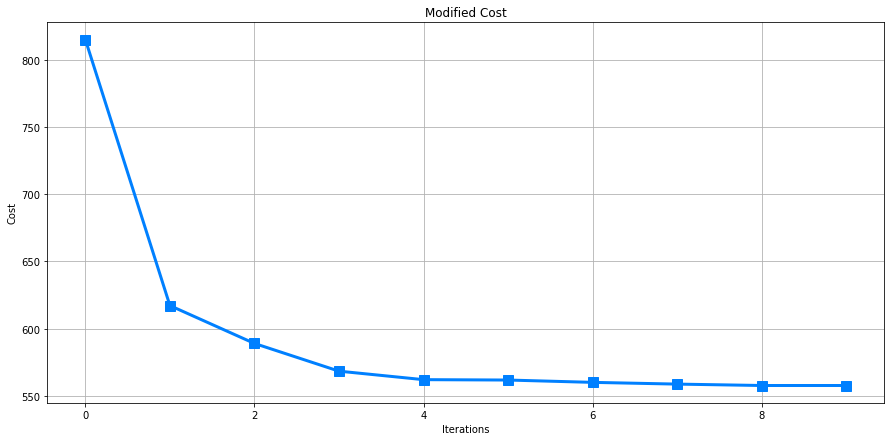

In [48]:
# plot cost
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(sax_laborables.cost_,"s-",linewidth=3,markersize=10,c="#0080FF")
ax.grid(True)
ax.set_title("Modified Cost")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")

In [49]:
dataset_laborables=df_lineas_laborables_filter.toPandas()

In [50]:
# get series
result_laborables = res_laborables.select(dataset_laborables.columns.values.tolist()+["assignation"]).toPandas()

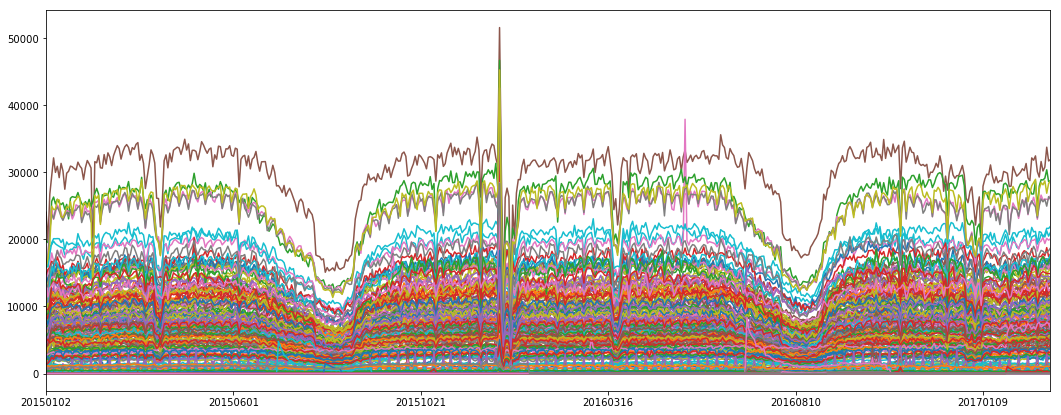

In [51]:
# plot time series
fig,ax = plt.subplots(figsize=(18,7))
cols=[c for c in dataset_laborables.columns if c not in {'linea'}]
result_laborables[cols].transpose().plot(ax=ax,legend=False)

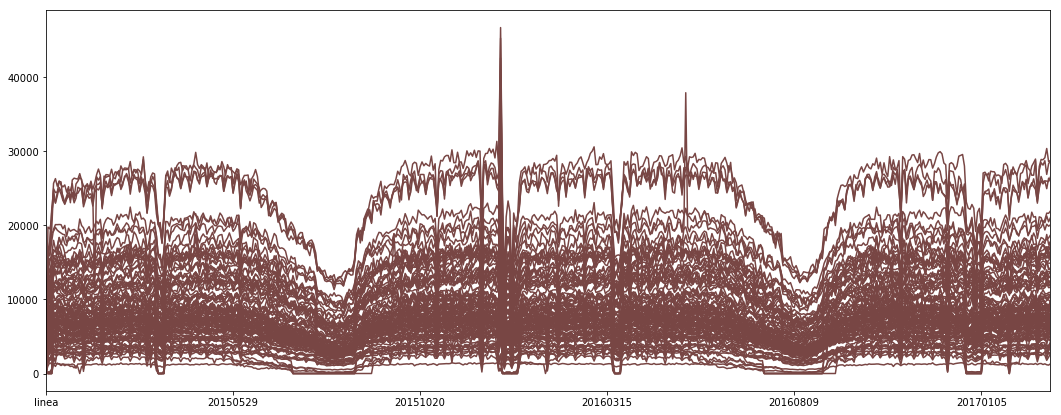

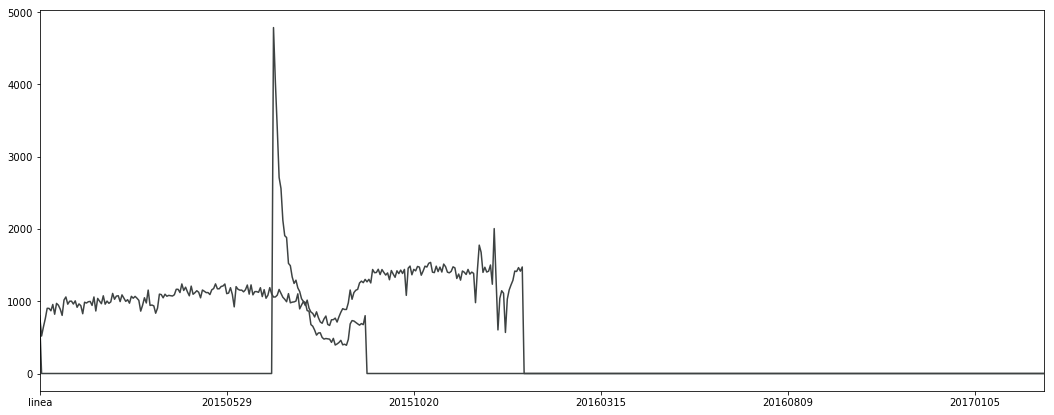

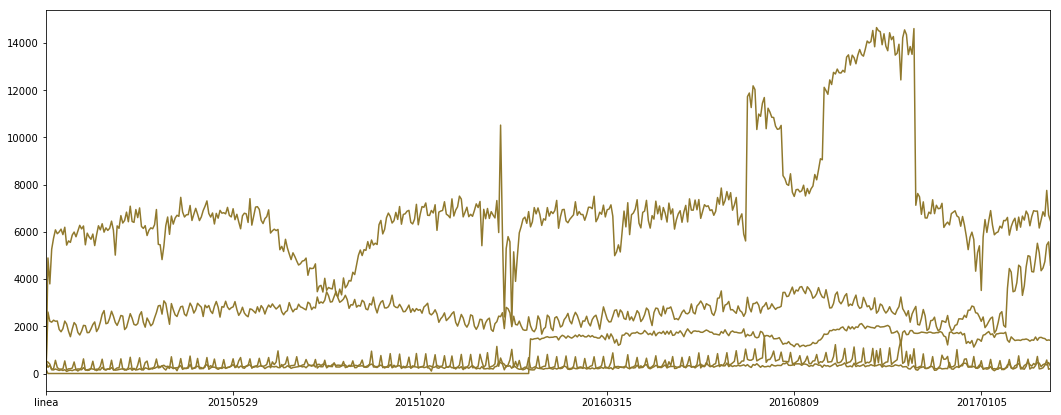

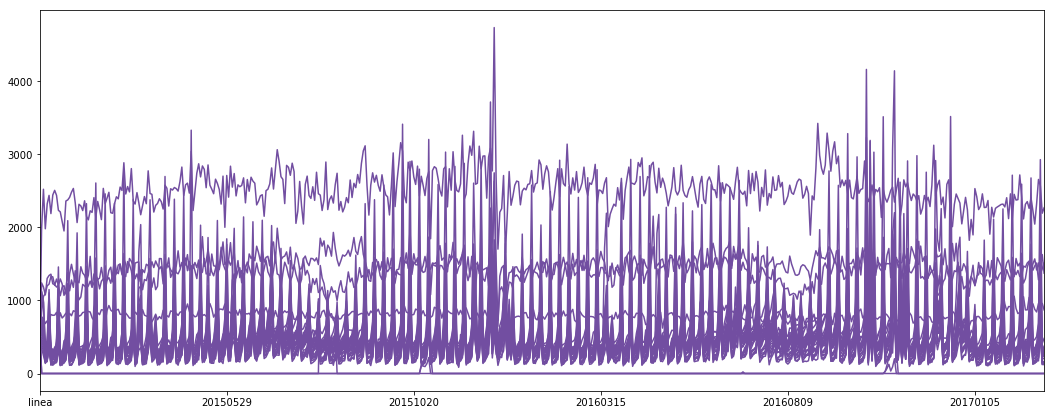

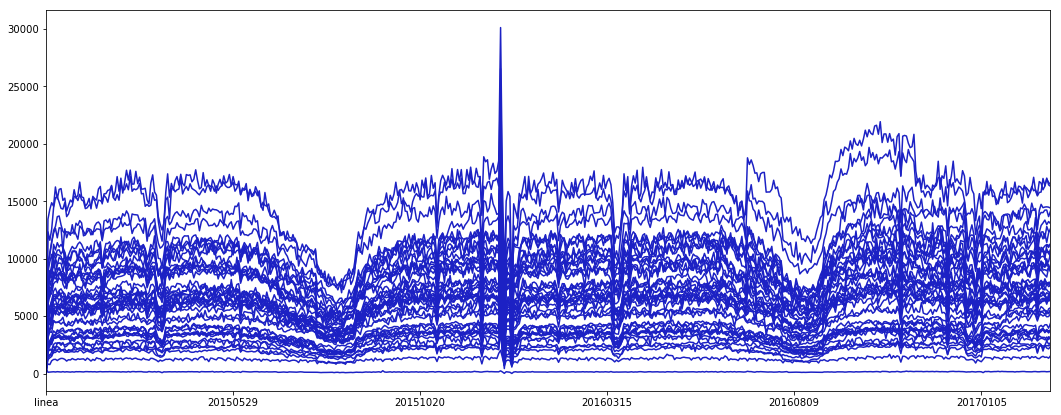

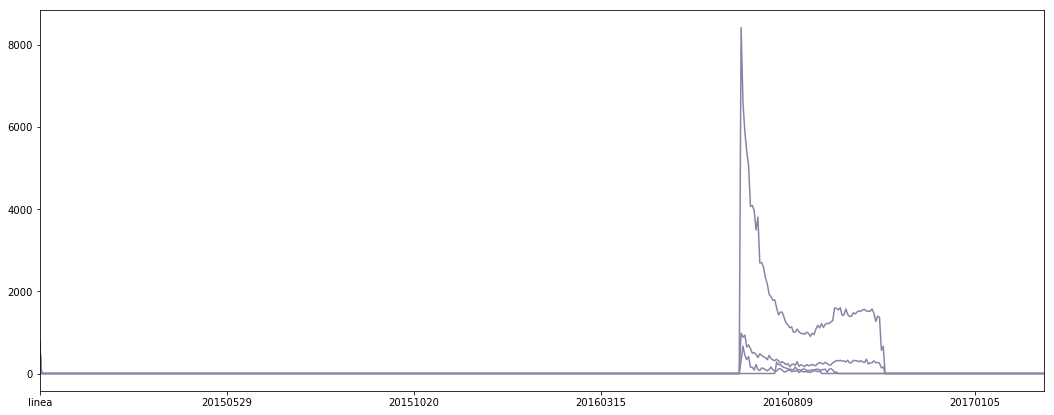

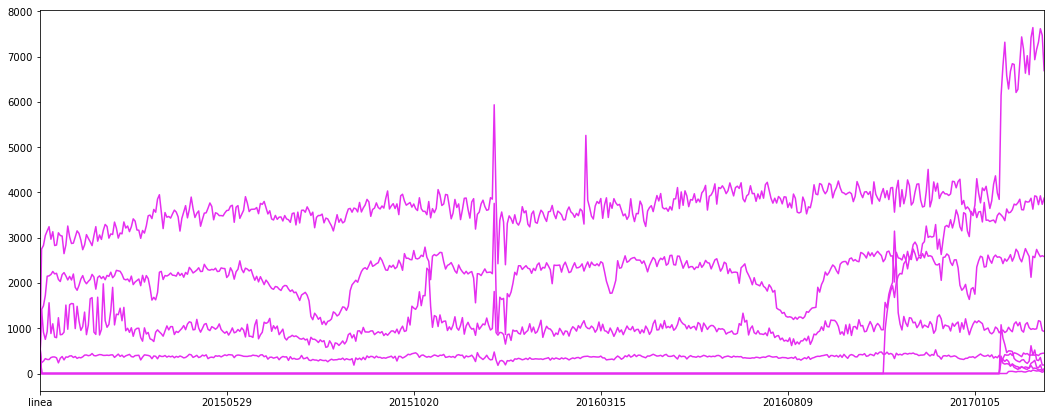

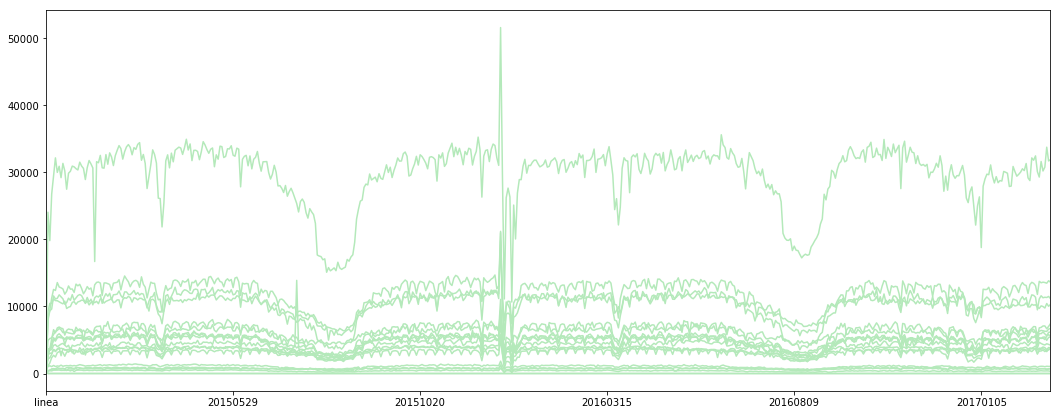

In [52]:
# plot clusterized time series
assignations_laborables = result_laborables["assignation"]

for k in range(8):
    fig,ax = plt.subplots(figsize=(18,7))
    selector = assignations_laborables==k

    if selector.any():
        dataset_laborables[selector].transpose().plot(ax=ax,legend=False,c=np.random.rand(3,1))

###### Guardamos el resultado en hive

In [53]:
result_labo = result_laborables[['linea','assignation']]
result_labo_df = sqlContext.createDataFrame(result_labo)
result_labo_df.show()

+-----+-----------+
|linea|assignation|
+-----+-----------+
|    1|          0|
|    2|          0|
|    3|          4|
|    4|          0|
|    5|          0|
|    6|          0|
|    7|          7|
|    8|          0|
|    9|          0|
|   10|          4|
|   11|          4|
|   12|          7|
|   14|          0|
|   15|          0|
|   16|          0|
|   17|          0|
|   18|          0|
|   19|          0|
|   20|          0|
|   21|          0|
+-----+-----------+
only showing top 20 rows



In [26]:
#result_laborables.to_csv('clustering_comun_laborables.csv',sep=";",index=False)
result_labo_df.write.format("orc").mode("overwrite").saveAsTable("emt_smartbus.clustering_general_laborables")

In [54]:
#Guardamos en un fichero para su comprobacion
result_laborables.to_csv('clustering_general_laborables_8_best.csv',sep=";",index=False)

### 4.2. Festivos

##### Fase de Preprocesado

In [40]:
#Ordenamos por fecha
df_lineas_pivot_festivos=df_lineas_festivos.orderBy(df_lineas_festivos.fecha.asc(),df_lineas_festivos.linea.asc())
df_lineas_pivot_festivos.show()

+--------+-----+----------+
|   fecha|linea|n_viajeros|
+--------+-----+----------+
|20150101|    1|      2151|
|20150101|    2|      2970|
|20150101|    3|      2635|
|20150101|    4|      1598|
|20150101|    5|      1566|
|20150101|    6|      4853|
|20150101|    7|       753|
|20150101|    8|      1785|
|20150101|    9|      3157|
|20150101|   10|      3444|
|20150101|   11|       688|
|20150101|   12|       835|
|20150101|   14|      1985|
|20150101|   15|      1923|
|20150101|   16|       925|
|20150101|   17|      4211|
|20150101|   18|      1920|
|20150101|   19|      2008|
|20150101|   20|      3833|
|20150101|   21|      3618|
+--------+-----+----------+
only showing top 20 rows



In [41]:
from pyspark.sql.functions import first

#transponer las columnas para que tengamos una columna por linea
df_lineas_pivot_festivos = df_lineas_pivot_festivos.groupBy('linea').pivot('fecha').agg(first("n_viajeros"))
df_lineas_pivot_festivos.show()

+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---

In [42]:
#Missing values
df_lineas_filter_festivos=df_lineas_pivot_festivos.na.fill(0.0)
df_lineas_filter_festivos.show()

+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---

In [43]:
#Ordenamos por fecha
df_lineas_filter_festivos=df_lineas_filter_festivos.orderBy(df_lineas_filter_festivos.linea.asc())
df_lineas_filter_festivos.show()

+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---

In [44]:
#Guardamos el dataset en cache
df_lineas_filter_festivos.cache()

DataFrame[linea: int, 20150101: bigint, 20150103: bigint, 20150104: bigint, 20150106: bigint, 20150110: bigint, 20150111: bigint, 20150117: bigint, 20150118: bigint, 20150124: bigint, 20150125: bigint, 20150131: bigint, 20150201: bigint, 20150207: bigint, 20150208: bigint, 20150214: bigint, 20150215: bigint, 20150221: bigint, 20150222: bigint, 20150228: bigint, 20150301: bigint, 20150307: bigint, 20150308: bigint, 20150314: bigint, 20150315: bigint, 20150319: bigint, 20150321: bigint, 20150322: bigint, 20150328: bigint, 20150329: bigint, 20150402: bigint, 20150403: bigint, 20150404: bigint, 20150405: bigint, 20150411: bigint, 20150412: bigint, 20150418: bigint, 20150419: bigint, 20150425: bigint, 20150426: bigint, 20150501: bigint, 20150502: bigint, 20150503: bigint, 20150509: bigint, 20150510: bigint, 20150515: bigint, 20150516: bigint, 20150517: bigint, 20150523: bigint, 20150524: bigint, 20150530: bigint, 20150531: bigint, 20150604: bigint, 20150606: bigint, 20150607: bigint, 201506

##### Fase de Clustering

In [45]:
# vector assembler
cols=[c for c in df_lineas_filter_festivos.columns if c not in {'linea'}]
assembler1 = VectorAssembler(inputCols=cols, outputCol="serie")
df_lineas_festivos_predict = assembler1.transform(df_lineas_filter_festivos)

In [46]:
sax_festivos = SAXKMeans(featuresCol="serie",predictionCol="prediction",k=8,numIntervals=5,alphabetSize=250,maxIter=15)


In [47]:
sax_festivos.fit(df_lineas_festivos_predict)

In [48]:
res_festivos = sax_festivos.transform(df_lineas_festivos_predict)

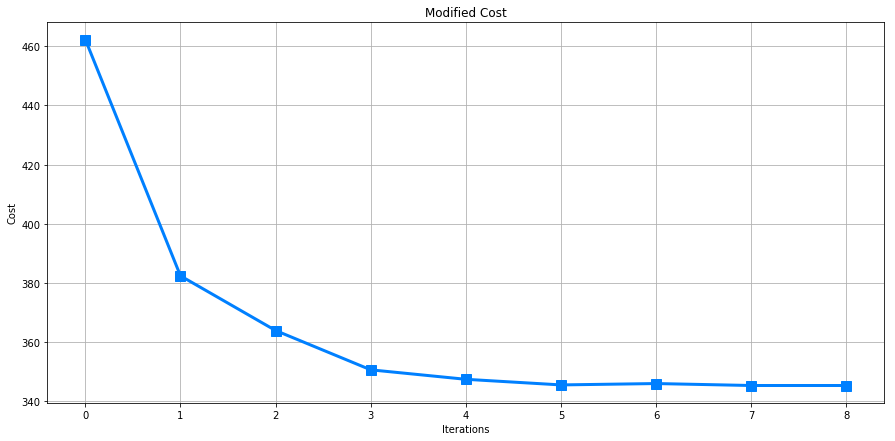

In [49]:
# plot cost
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(sax_festivos.cost_,"s-",linewidth=3,markersize=10,c="#0080FF")
ax.grid(True)
ax.set_title("Modified Cost")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")

In [50]:
dataset_festivos=df_lineas_filter_festivos.toPandas()

In [51]:
# get series
result_festivos = res_festivos.select(dataset_festivos.columns.values.tolist()+["assignation"]).toPandas()

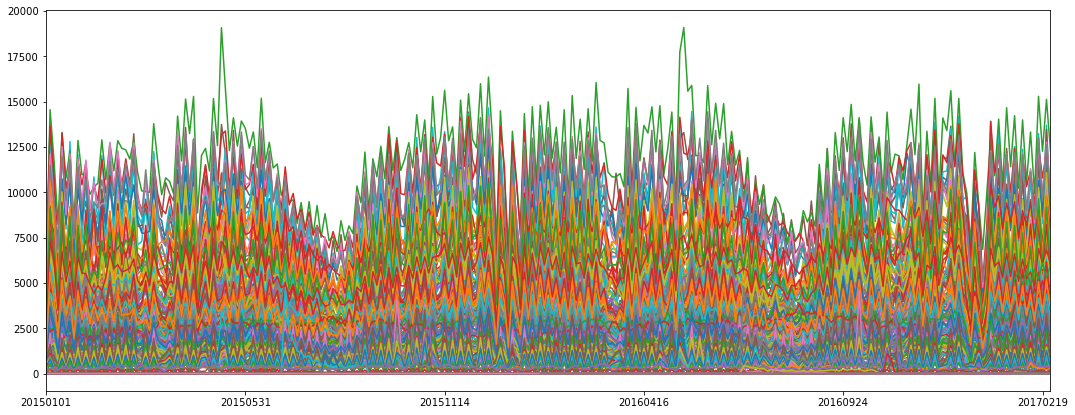

In [52]:
# plot time series
fig,ax = plt.subplots(figsize=(18,7))
cols=[c for c in dataset_festivos.columns if c not in {'linea'}]
result_festivos[cols].transpose().plot(ax=ax,legend=False)

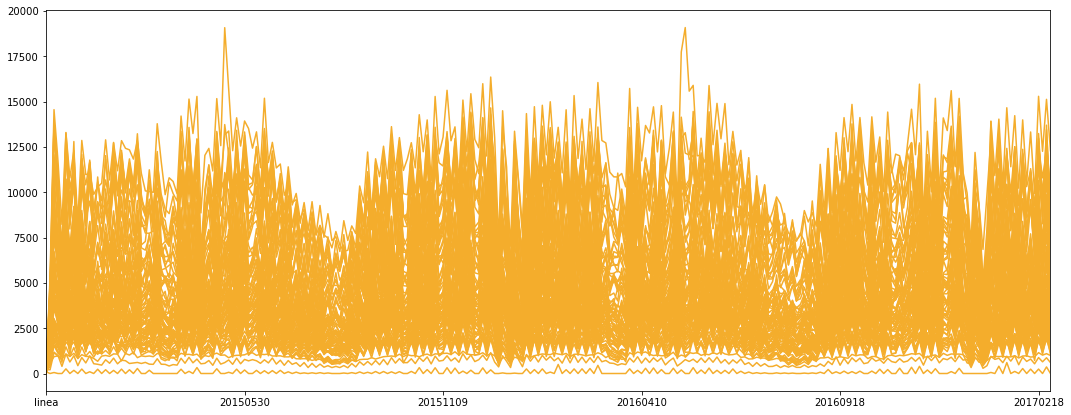

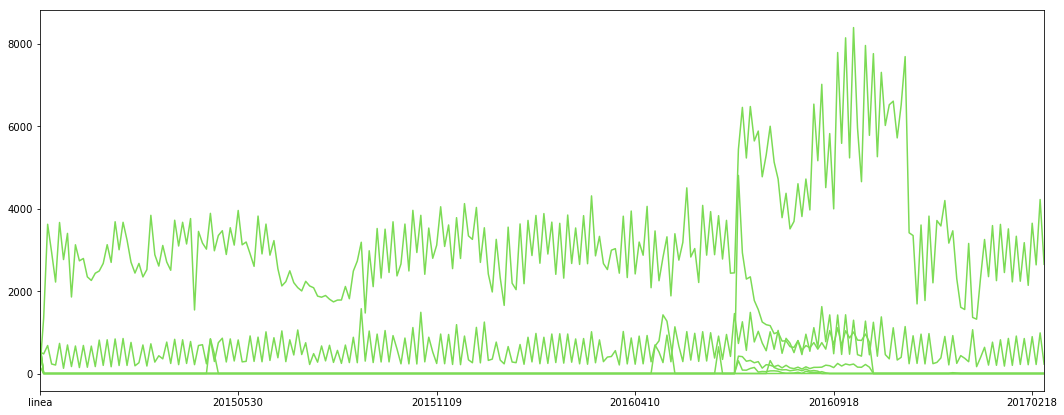

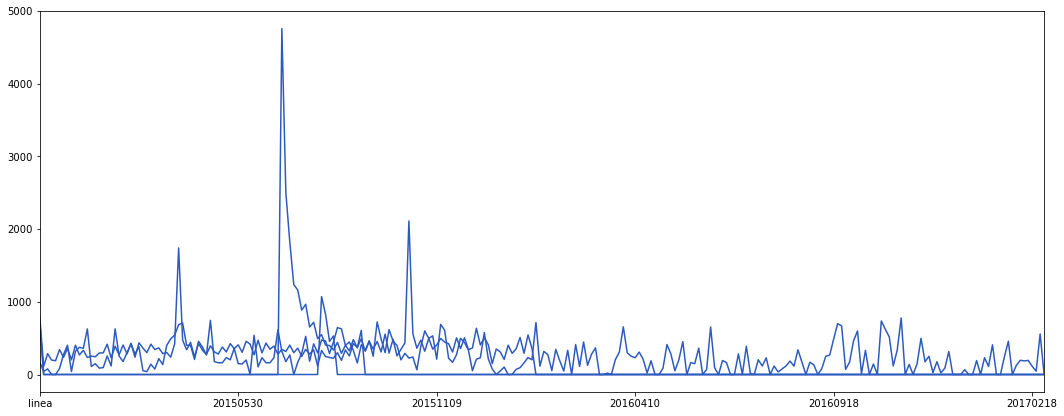

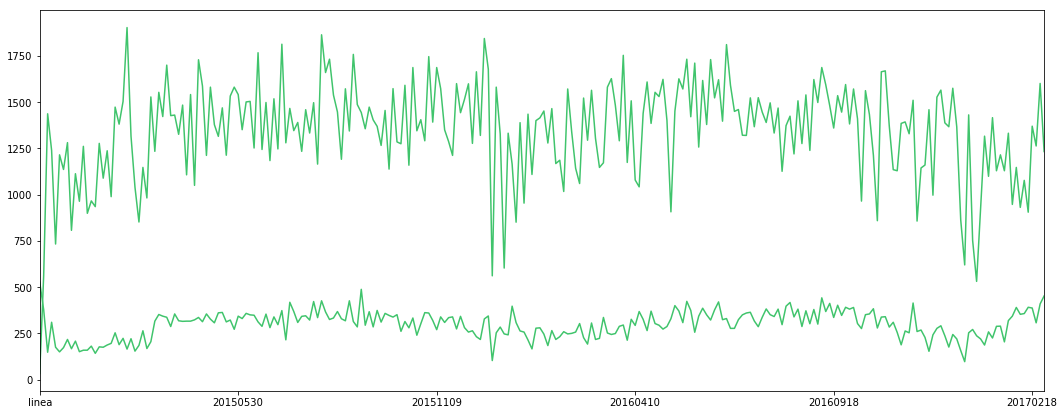

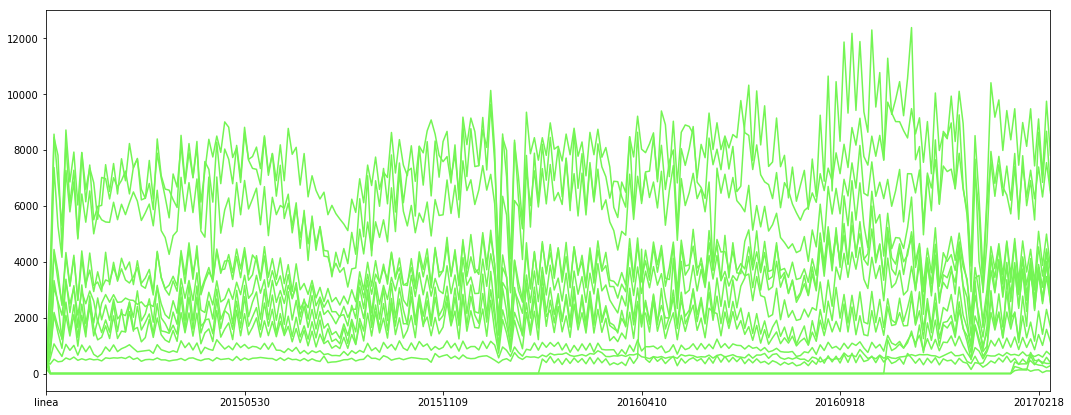

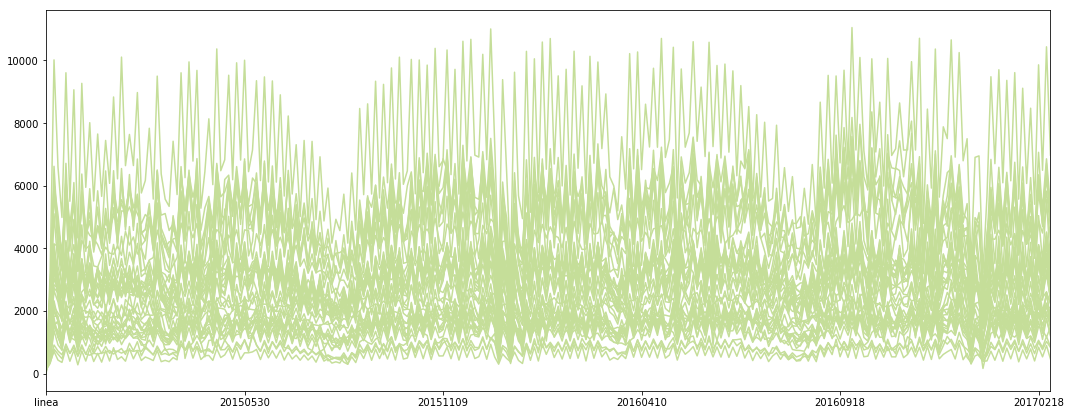

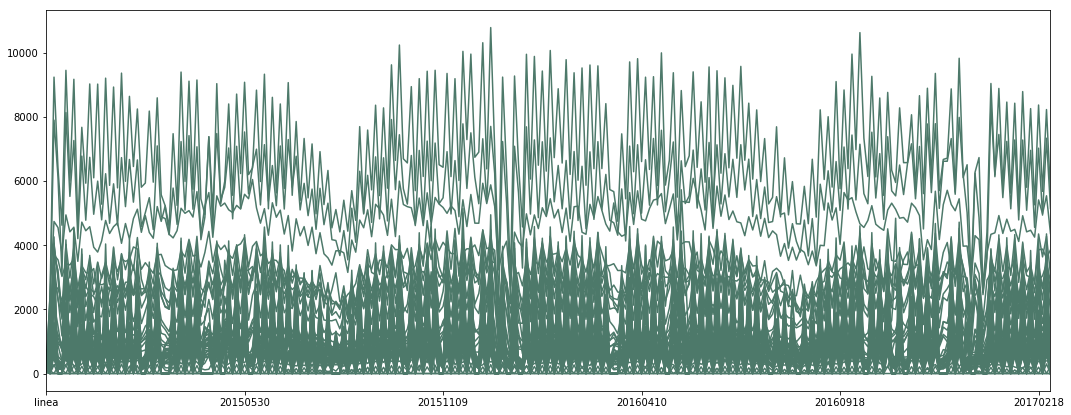

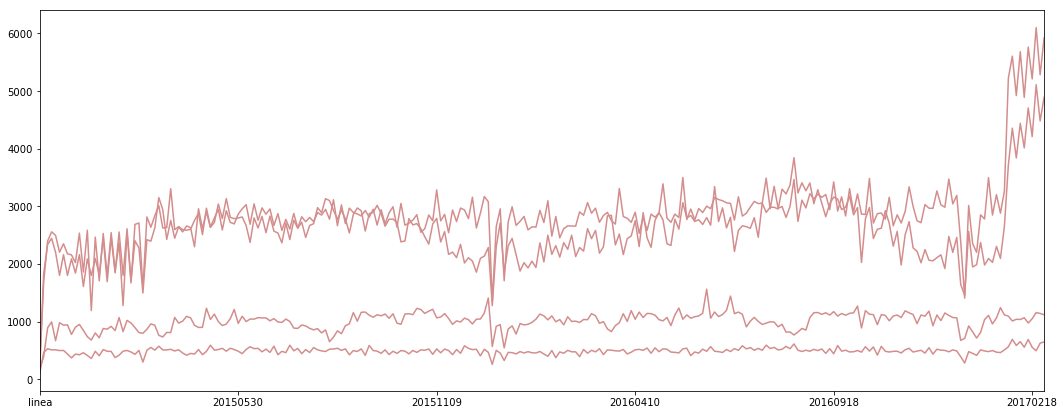

In [53]:
# plot clusterized time series
assignations_festivos = result_festivos["assignation"]

for k in range(8):
    fig,ax = plt.subplots(figsize=(18,7))
    selector = assignations_festivos==k

    if selector.any():
        dataset_festivos[selector].transpose().plot(ax=ax,legend=False,c=np.random.rand(3,1))

###### Guardamos el resultado en hive

In [54]:
result_fest = result_festivos[['linea','assignation']]
result_fest_df = sqlContext.createDataFrame(result_fest)
result_fest_df.show()

+-----+-----------+
|linea|assignation|
+-----+-----------+
|    1|          0|
|    2|          0|
|    3|          5|
|    4|          5|
|    5|          0|
|    6|          0|
|    7|          0|
|    8|          5|
|    9|          0|
|   10|          4|
|   11|          5|
|   12|          0|
|   14|          0|
|   15|          0|
|   16|          0|
|   17|          0|
|   18|          0|
|   19|          0|
|   20|          0|
|   21|          0|
+-----+-----------+
only showing top 20 rows



In [ ]:
#result_laborables.to_csv('clustering_comun_laborables.csv',sep=";",index=False)
result_fest_df.write.format("orc").mode("overwrite").saveAsTable("emt_smartbus.clustering_general_festivos")

In [55]:
#Guardamos en un fichero para su comprobacion
result_festivos.to_csv('clustering_general_festivos_8.csv',sep=";",index=False)